# Dataset

In [73]:
import torch
from torch.utils import data
import ast
import pandas as pd
import numpy as np

max_clusters = 10

class ClusterDataset(data.Dataset):
    def __init__(self, csv_file, group, sequence_length=15, future_steps=1):
        """
        Args:
            csv_file (str): Path to the modified clusters CSV file.
            sequence_length (int): Number of steps in each sequence for training.
        """
        self.sequence_length = sequence_length
        self.future_steps = future_steps
        df = pd.read_csv(csv_file)
        print(group)
        # Filter by group and sort by start_date
        df = df[df['group'] == group].copy()
        df['start_date'] = pd.to_datetime(df['start_date'])
        df = df.sort_values(by='start_date')
        
        # Group by start_date to create sets of clusters for each timestep
        self.sequence = []
        for start_date, group_df in df.groupby('start_date'):
            clusters = group_df[['lat', 'lon', 'volume']].values
            self.sequence.append((start_date, clusters))

        #self.max_clusters = max(len(clusters) for _, clusters in self.sequence)
        self.max_clusters = max_clusters
    def __len__(self):
        return max(0, len(self.sequence) - self.sequence_length - self.future_steps)

    def __getitem__(self, idx):
        """
        Returns a sequence of cluster sets for training.
        Each sequence step is padded to the same length.
        """
        input_sequence = [clusters for _, clusters in self.sequence[idx:idx + self.sequence_length]]
        target_sequence = [self.sequence[idx + self.sequence_length + self.future_steps][1]]
        return self.pad_sequence(input_sequence), self.pad_sequence(target_sequence), torch.tensor(len(target_sequence[0]), dtype=torch.float32)

    def pad_sequence(self, sequence):
        """
        Pads a variable-length sequence of sets to the maximum number of clusters in the sequence.
        Each set is padded with (0.0, 0.0, 0.0) until it reaches the max length.
        """
        padded_sequence = []
        for step in sequence:
            # Pad each step with (0.0, 0.0, 0.0) until it reaches max_clusters length
            if len(step) < self.max_clusters:
                padded_step = np.pad(step, ((0, self.max_clusters - len(step)), (0, 0)), mode='constant', constant_values=0.0)
                padded_sequence.append(padded_step)
            else:
                padded_sequence.append(step)

        return torch.tensor(padded_sequence, dtype=torch.float32)  # Shape: (sequence_length, max_clusters, 3)

# LSTM model

In [74]:
import torch
import torch.nn as nn
import torch.nn.functional as F

#############################################
# 1. DeepSets Encoder for a single time step
#############################################

class DeepSetEncoder(nn.Module):
    def __init__(self, input_dim=3, hidden_dim=64, output_dim=64):
        """
        Encodes a set of clusters (each with `input_dim` features) into a fixed-length vector.
        """
        super(DeepSetEncoder, self).__init__()
        self.mlp = nn.Sequential(
            nn.Linear(input_dim, hidden_dim),
            nn.LeakyReLU(),
            nn.Linear(hidden_dim, output_dim)
        )

    def forward(self, x):
        """
        x: Tensor of shape (batch, num_clusters, 3)
        """
        mask = (x.abs().sum(dim=-1) != 0).float()  # Mask out zero-padded clusters
        embed = self.mlp(x)

        aggregated_avg = (embed * mask.unsqueeze(-1)).sum(dim=2) / mask.sum(dim=2).clamp(min=1).unsqueeze(-1)
        count = mask.sum(dim=2).unsqueeze(-1)  # shape: (batch, seq_len, 1)
        aggregated = torch.cat([aggregated_avg, count], dim=-1)

        return aggregated  # Average the embeddings of all clusters

#############################################
# 2. LSTM Forecaster for temporal prediction
#############################################

class ForecastModel(nn.Module):
    def __init__(self, input_dim, hidden_dim, lstm_hidden_dim, future_steps=1, max_clusters=10):
        super(ForecastModel, self).__init__()
        self.future_steps = future_steps
        self.max_clusters = max_clusters
        self.input_dim = input_dim

        self.deepset = DeepSetEncoder(input_dim, hidden_dim, hidden_dim)
        self.lstm = nn.LSTM(hidden_dim+1, lstm_hidden_dim, num_layers=2, batch_first=True, dropout=0.1)
        
        self.cluster_count_predictor = nn.Sequential(
            nn.Linear(lstm_hidden_dim, lstm_hidden_dim//2),
            nn.LeakyReLU(),
            nn.Linear(lstm_hidden_dim//2, 1),
        )
        
        self.cluster_decoder = nn.Sequential(
            nn.Linear(lstm_hidden_dim, lstm_hidden_dim),
            nn.LeakyReLU(),
            nn.Linear(lstm_hidden_dim, max_clusters * input_dim)
        )  # Predict cluster properties

    def forward(self, x):
        aggregated = self.deepset(x)
        lstm_out, _ = self.lstm(aggregated)
        # Predict the number of clusters
        num_clusters = self.cluster_count_predictor(lstm_out[:, -1, :])

        # Predict cluster properties for each cluster
        cluster_predictions = self.cluster_decoder(lstm_out[:, -1, :])
        cluster_predictions = cluster_predictions.view(-1, self.max_clusters, self.input_dim)
        # Mask out predictions for non-existent clusters
        mask = torch.arange(self.max_clusters, device=cluster_predictions.device).unsqueeze(0) < num_clusters.round()
        cluster_predictions = cluster_predictions * mask.unsqueeze(-1).float()
        cluster_predictions = torch.where(cluster_predictions == 0, torch.tensor(0.0, device=cluster_predictions.device), cluster_predictions)
        
        return torch.squeeze(num_clusters), torch.unsqueeze(cluster_predictions, 1)

# Train

In [75]:
import torch
import math

def haversine_loss(pred_coords, target_coords):
    """
    Computes the mean Haversine distance between predicted and target coordinates.
    
    Both pred_coords and target_coords should be tensors of shape (..., 2)
    where the last dimension is [latitude, longitude] in degrees.
    """
    R = 6371000.0  # Earth's radius in meters
    # Convert degrees to radians
    pred_rad = pred_coords * math.pi / 180.0
    target_rad = target_coords * math.pi / 180.0
    
    # Difference in coordinates
    dlat = pred_rad[..., 0] - target_rad[..., 0]
    dlon = pred_rad[..., 1] - target_rad[..., 1]
    
    # Haversine formula
    a = torch.sin(dlat/2)**2 + torch.cos(pred_rad[..., 0]) * torch.cos(target_rad[..., 0]) * torch.sin(dlon/2)**2
    c = 2 * torch.atan2(torch.sqrt(a), torch.sqrt(1-a))
    distances = R * c  # distance in meters
    
    return torch.mean(distances)

In [ ]:
class EarlyStopping:
    def __init__(self, patience=5, min_delta=0):
        self.patience = patience
        self.min_delta = min_delta
        self.counter = 0
        self.best_loss = None
        self.early_stop = False

    def __call__(self, val_loss):
        if val_loss == 0.:
            return
        if self.best_loss is None:
            self.best_loss = val_loss
        elif val_loss > self.best_loss - self.min_delta:
            self.counter += 1
            if self.counter >= self.patience:
                self.early_stop = True
        else:
            self.best_loss = val_loss
            self.counter = 0

    def reset(self):
        self.counter = 0
        self.best_loss = None
        self.early_stop = False

early_stopping = EarlyStopping(patience=50)

In [ ]:
import torch
import torch.optim as optim
import torch.nn as nn

def train_loop(dataset):
    dataloader = data.DataLoader(dataset, batch_size=8, shuffle=True)

    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model = ForecastModel(input_dim=3, 
                        hidden_dim=128,
                        lstm_hidden_dim=512,
                        future_steps=1,
                        max_clusters=max_clusters)
    model.to(device)

    optimizer = optim.AdamW(model.parameters(), lr=2e-6) #0.000004
    loss_fn = nn.L1Loss()
    loss2_fn = nn.L1Loss()
    num_epochs = 1500

    for epoch in range(num_epochs):
        model.train()
        total_num_clusters_loss = 0.0
        total_hav_loss = 0.0
        total_cluster_loss = 0.0
        num_batches = 0
        for batch_inputs, batch_targets, true_num_clusters in dataloader:
            model.train()
            # Move data to device
            batch_inputs = batch_inputs.to(device)    
            batch_targets = batch_targets.to(device)     
            true_num_clusters = true_num_clusters.to(device)

            n_clusters, predictions = model(batch_inputs)

            num_clusters_loss = loss2_fn(n_clusters, true_num_clusters)

            mask = torch.arange(max_clusters, device=device).unsqueeze(0) < torch.min(n_clusters.round_(), true_num_clusters).unsqueeze(-1)
            batch_targets = batch_targets * mask.unsqueeze(1).unsqueeze(-1).float()  
            predictions = predictions * mask.unsqueeze(1).unsqueeze(-1).float()


            preds_coords = predictions.squeeze(1)[..., :2]  # shape: (batch, max_clusters, 2)
            targets_coords = batch_targets.squeeze(1)[..., :2]
            pred_volume = predictions.squeeze(1)[..., 2]  # volume
            target_volume = batch_targets.squeeze(1)[..., 2]  # volume
            
            valid_mask = mask.bool()  # shape: (batch, max_clusters, 1)
            valid_pred_coords = preds_coords[valid_mask].view(-1, 2)      # shape: (N, 2)
            valid_target_coords = targets_coords[valid_mask].view(-1, 2)
            
            if valid_pred_coords.numel() > 0:
                hav_loss = haversine_loss(valid_pred_coords, valid_target_coords)
            else:
                hav_loss = torch.tensor(0.0, device=device)

            volume_loss = loss_fn(pred_volume, target_volume)

            #total_loss = hav_loss*1 + volume_loss*0.01 + num_clusters_loss*200000 # diminuire num_cluster_loss
            total_loss = num_clusters_loss*10 + hav_loss*0.01 + volume_loss*0.0001

            optimizer.zero_grad()
            total_loss.backward()
            optimizer.step()
            
            total_num_clusters_loss += num_clusters_loss.item()
            total_hav_loss += hav_loss.item()
            total_cluster_loss += volume_loss.item()

            num_batches += 1
        
        avg_num_clusters_loss = total_num_clusters_loss / num_batches
        avg_hav_loss = total_hav_loss / num_batches
        avg_cluster_loss = total_cluster_loss / num_batches

        """ early_stopping(total_loss)
        if early_stopping.early_stop:
            print("Early stopping triggered!")
            break """
        if epoch % 10 == 0:
            print(f"Epoch {epoch+1}/{num_epochs}, NumClusters Loss: {avg_num_clusters_loss:.4f}, Haversine Loss: {avg_hav_loss:.4f}m, Volume Loss: {avg_cluster_loss:.4f}")

    return model, avg_num_clusters_loss, avg_hav_loss, avg_cluster_loss


In [70]:
results = pd.DataFrame(columns=['model', 'num_clusters_loss', 'hav_loss', 'volume_loss'])
groups = [ 'aesthetic', 'infrastructure','environmental', 'wildlife', 'safety'  ]   

eps = 0.008
window_size = 14

for seq_len in [20, 30, 40]:
    for group in groups:
        test_dataset = ClusterDataset("../data/clusters/clusters_eps_0.008_window_14.csv", sequence_length=seq_len, group=group, future_steps=7)
        print(len(test_dataset))
        if len(test_dataset) == 0:
            continue

        print(f"Training {group} model for eps={eps}, window_size={window_size}, seq_len={seq_len}")
        model, num_clusters_loss, hav_loss, volume_loss = train_loop(test_dataset)
        torch.save(model.state_dict(), f'../models/seq_{seq_len}_eps_{eps}_window_{window_size}_{group}_model.pth')

        new_row = pd.DataFrame([{
            'model': f'seq_{seq_len}_eps_{eps}_window_{window_size}_{group}',
            'num_clusters_loss': num_clusters_loss,
            'hav_loss': hav_loss,
            'volume_loss': volume_loss
        }])
        results = pd.concat([results, new_row], ignore_index=True)
        
results.to_csv('../results/training_results.csv', index=False)

aesthetic
92
Training aesthetic model for eps=0.008, window_size=14, seq_len=20
Epoch 1/1200, NumClusters Loss: 1.6889, Haversine Loss: 0.0000m, Volume Loss: 0.0000
Epoch 11/1200, NumClusters Loss: 1.4286, Haversine Loss: 0.0000m, Volume Loss: 0.0000
Epoch 21/1200, NumClusters Loss: 1.1844, Haversine Loss: 4926543.2917m, Volume Loss: 1.3709
Epoch 31/1200, NumClusters Loss: 0.7151, Haversine Loss: 4821355.7083m, Volume Loss: 1.3970
Epoch 41/1200, NumClusters Loss: 0.4436, Haversine Loss: 4775331.5417m, Volume Loss: 2.0114
Epoch 51/1200, NumClusters Loss: 0.3396, Haversine Loss: 4650239.4583m, Volume Loss: 1.9999
Epoch 61/1200, NumClusters Loss: 0.3487, Haversine Loss: 4512915.0833m, Volume Loss: 1.9917
Epoch 71/1200, NumClusters Loss: 0.3368, Haversine Loss: 4385049.1667m, Volume Loss: 1.9619
Epoch 81/1200, NumClusters Loss: 0.3364, Haversine Loss: 4261674.7083m, Volume Loss: 1.9385
Epoch 91/1200, NumClusters Loss: 0.3460, Haversine Loss: 4135919.8542m, Volume Loss: 1.9022
Epoch 101/120

C:\Users\Utente\AppData\Local\Temp\ipykernel_38392\853385474.py:24: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  results = pd.concat([results, new_row], ignore_index=True)


infrastructure
92
Training infrastructure model for eps=0.008, window_size=14, seq_len=20
Epoch 1/1200, NumClusters Loss: 1.3081, Haversine Loss: 0.0000m, Volume Loss: 0.0000
Epoch 11/1200, NumClusters Loss: 1.0495, Haversine Loss: 0.0000m, Volume Loss: 0.0000
Epoch 21/1200, NumClusters Loss: 0.8125, Haversine Loss: 4919098.4583m, Volume Loss: 1.1116
Epoch 31/1200, NumClusters Loss: 0.4314, Haversine Loss: 4804015.2083m, Volume Loss: 1.0878
Epoch 41/1200, NumClusters Loss: 0.4847, Haversine Loss: 4600235.2500m, Volume Loss: 1.0480
Epoch 51/1200, NumClusters Loss: 0.4733, Haversine Loss: 4364080.1667m, Volume Loss: 1.0351
Epoch 61/1200, NumClusters Loss: 0.4098, Haversine Loss: 4137228.7292m, Volume Loss: 0.9982
Epoch 71/1200, NumClusters Loss: 0.3875, Haversine Loss: 3923261.3958m, Volume Loss: 0.9738
Epoch 81/1200, NumClusters Loss: 0.3974, Haversine Loss: 3725611.5833m, Volume Loss: 0.9200
Epoch 91/1200, NumClusters Loss: 0.4189, Haversine Loss: 3543117.3333m, Volume Loss: 0.8868
Epo

e:\citysentry-server\citysentry\Lib\site-packages\torch\nn\modules\loss.py:128: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.l1_loss(input, target, reduction=self.reduction)


Epoch 11/1200, NumClusters Loss: 1.0008, Haversine Loss: 0.0000m, Volume Loss: 0.0000
Epoch 21/1200, NumClusters Loss: 0.7546, Haversine Loss: 0.0000m, Volume Loss: 0.0000
Epoch 31/1200, NumClusters Loss: 0.5735, Haversine Loss: 4933310.1111m, Volume Loss: 0.4974
Epoch 41/1200, NumClusters Loss: 0.2348, Haversine Loss: 4857038.1111m, Volume Loss: 0.5103
Epoch 51/1200, NumClusters Loss: 0.2941, Haversine Loss: 4742402.8333m, Volume Loss: 0.4865
Epoch 61/1200, NumClusters Loss: 0.1170, Haversine Loss: 4591044.1667m, Volume Loss: 0.5090
Epoch 71/1200, NumClusters Loss: 0.1158, Haversine Loss: 4437371.0556m, Volume Loss: 0.4497
Epoch 81/1200, NumClusters Loss: 0.1171, Haversine Loss: 4294436.5000m, Volume Loss: 0.4312
Epoch 91/1200, NumClusters Loss: 0.2120, Haversine Loss: 4158718.3333m, Volume Loss: 0.3936
Epoch 101/1200, NumClusters Loss: 0.2124, Haversine Loss: 4021160.1944m, Volume Loss: 0.3518
Epoch 111/1200, NumClusters Loss: 0.2148, Haversine Loss: 3890189.8611m, Volume Loss: 0.327

# Testing

In [78]:
import torch

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = ForecastModel(input_dim=3, 
                    hidden_dim=128,
                    lstm_hidden_dim=512,
                    future_steps=1,
                    max_clusters=max_clusters)
model.to(device)
group = 'infrastructure'
eps = 0.008
window_size = 14

for seq_len in [20, 40, 30]:
    print(f"Testing model for eps={eps}, window_size={window_size}, seq_len={seq_len}")

    model.load_state_dict(torch.load(f'../models/seq_{seq_len}_eps_{eps}_window_{window_size}_{group}_model.pth'))
    test_dataset = ClusterDataset(f"../data/clusters/clusters_eps_{eps}_window_{window_size}.csv", sequence_length=seq_len, group=group, future_steps=7)
    test_loader = data.DataLoader(test_dataset, batch_size=1, shuffle=True)

    # Set your device and ensure your model is loaded/trained
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)
    model.eval()  # switch to evaluation mode

    mape_total = 0.0
    num_batches = 0

    all_predictions = []
    all_targets = []

    with torch.no_grad():
        for batch_inputs, batch_targets, true_num_clusters in test_loader:
            batch_inputs = batch_inputs.to(device)
            batch_targets = batch_targets.to(device)
            true_num_clusters = true_num_clusters.to(device)
            
            n_clusters, predictions = model(batch_inputs)
            print(torch.abs(n_clusters.round() - true_num_clusters))

            mask = torch.arange(max_clusters, device=device).unsqueeze(0) < torch.min(n_clusters.round_(), true_num_clusters).unsqueeze(-1)
            batch_targets = batch_targets * mask.unsqueeze(1).unsqueeze(-1).float()  
            predictions = predictions * mask.unsqueeze(1).unsqueeze(-1).float()

            preds_coords = predictions.squeeze(1)[..., :2]  # shape: (batch, max_clusters, 2)
            targets_coords = batch_targets.squeeze(1)[..., :2]
            
            valid_mask = mask.bool()  # shape: (batch, max_clusters, 1)
            valid_pred_coords = preds_coords[valid_mask].view(-1, 2)      # shape: (N, 2)
            valid_target_coords = targets_coords[valid_mask].view(-1, 2)

            if valid_pred_coords.numel() > 0:
                hav_loss = haversine_loss(valid_pred_coords, valid_target_coords)
                mape_total += hav_loss
            num_batches += 1
            all_predictions.append(predictions)
            all_targets.append(batch_targets)

    avg_mape = mape_total / num_batches
    print(f"Haversine acc: {avg_mape:.2f}m")

Testing model for eps=0.008, window_size=14, seq_len=20
infrastructure
tensor([0.], device='cuda:0')
tensor([1.], device='cuda:0')
tensor([0.], device='cuda:0')
tensor([0.], device='cuda:0')
tensor([0.], device='cuda:0')
tensor([1.], device='cuda:0')
tensor([1.], device='cuda:0')
tensor([0.], device='cuda:0')
tensor([1.], device='cuda:0')
tensor([0.], device='cuda:0')
tensor([0.], device='cuda:0')
tensor([0.], device='cuda:0')
tensor([0.], device='cuda:0')
tensor([1.], device='cuda:0')
tensor([1.], device='cuda:0')
tensor([1.], device='cuda:0')
tensor([0.], device='cuda:0')
tensor([1.], device='cuda:0')
tensor([1.], device='cuda:0')
tensor([0.], device='cuda:0')
tensor([1.], device='cuda:0')
tensor([1.], device='cuda:0')
tensor([0.], device='cuda:0')
tensor([0.], device='cuda:0')
tensor([0.], device='cuda:0')
tensor([0.], device='cuda:0')
tensor([1.], device='cuda:0')
tensor([0.], device='cuda:0')
tensor([0.], device='cuda:0')
tensor([0.], device='cuda:0')
tensor([0.], device='cuda:0')

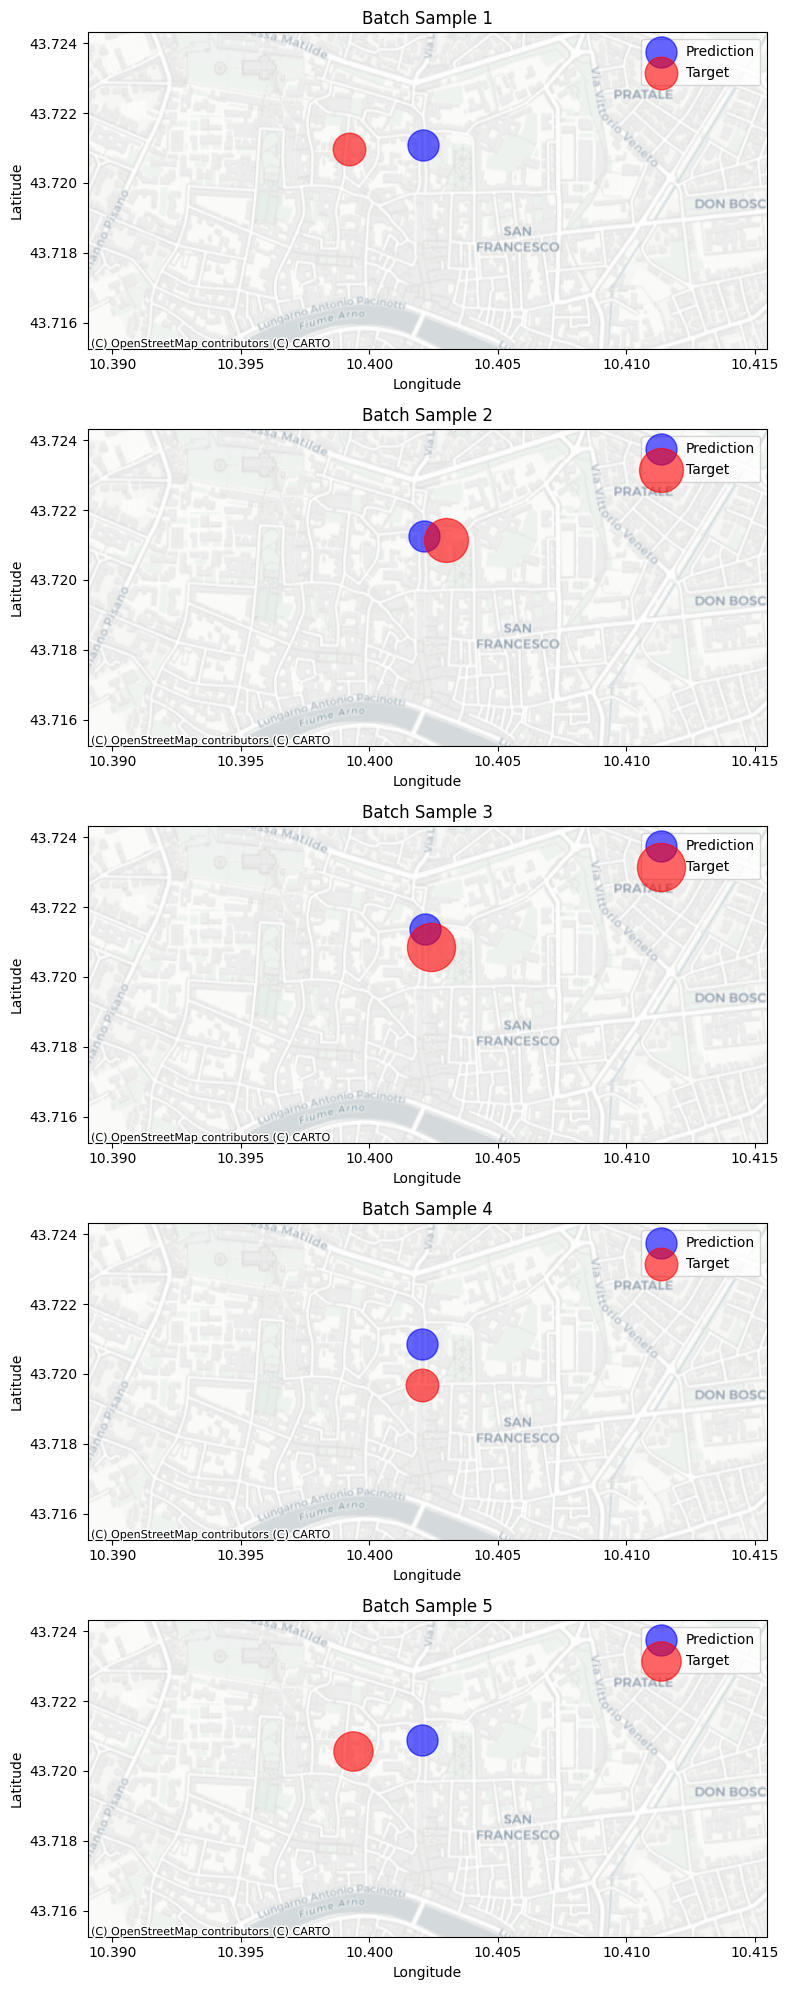

In [79]:
import matplotlib.pyplot as plt
import contextily as ctx
import numpy as np

# Assume predictions and batch_targets have shape (batch, 1, max_clusters, 3)
predictions = torch.stack(all_predictions, dim=0)
targets = torch.stack(all_targets, dim=0)
predictions.squeeze_(1)
targets.squeeze_(1)

batch, seq_len, max_clusters, feat_dim = predictions.shape

# Convert tensors to numpy arrays
predictions_np = predictions.detach().cpu().numpy()  # shape: (batch, 1, max_clusters, 3)
targets_np = targets.detach().cpu().numpy()     # shape: (batch, 1, max_clusters, 3)

# Function to extract valid (non-padded) coordinates from a tensor array
def extract_valid_coords(arr):
    # Reshape to (total_clusters, 3)
    arr = arr.reshape(-1, 3)
    # Filter out padded clusters (assume padding: lat==0 and lon==0)
    valid = arr[(arr[:, 0] != 0) & (arr[:, 1] != 0)]
    return valid

# Extract valid coordinates from both predictions and targets
valid_pred = extract_valid_coords(predictions_np)
valid_target = extract_valid_coords(targets_np)

# Combine the valid coordinates from both sources
all_valid = np.concatenate([valid_pred, valid_target], axis=0)

# Compute global limits for latitude and longitude
if all_valid.shape[0] > 0:
    lat_min, lat_max = all_valid[:, 0].min(), all_valid[:, 0].max()
    lon_min, lon_max = all_valid[:, 1].min(), all_valid[:, 1].max()
else:
    # Default limits if no valid data exists
    lat_min, lat_max = -90, 90
    lon_min, lon_max = -180, 180

# Optionally add some margin around the global limits
lat_margin = (lat_max - lat_min) * 0.05
lon_margin = (lon_max - lon_min) * 0.05
lat_min -= lat_margin
lat_max += lat_margin
lon_min -= lon_margin
lon_max += lon_margin

# Define a scaling factor for marker sizes (to represent volume)
size_scale = 50

# Create one subplot per batch sample
batch = min(5, batch)
fig, axs = plt.subplots(batch, 1, figsize=(8, 4 * batch), squeeze=False)

for b in range(batch):
    if b > 20:
        break
    ax = axs[b, 0]
    # For each batch sample, extract the clusters for the single time step (index 0)
    pred_data = predictions_np[b, 0, :, :]  # shape: (max_clusters, 3)
    target_data = targets_np[b, 0, :, :]      # shape: (max_clusters, 3)

    # Filter out padded clusters (assume lat and lon are 0 for padded clusters)
    valid_pred = pred_data[(pred_data[:, 0] != 0) & (pred_data[:, 1] != 0)]
    valid_target = target_data[(target_data[:, 0] != 0) & (target_data[:, 1] != 0)]
    
    # Plot predictions with marker size representing volume (blue)
    if valid_pred.size > 0:
        pred_lat = valid_pred[:, 0]
        pred_lon = valid_pred[:, 1]
        pred_volume = valid_pred[:, 2]
        ax.scatter(pred_lon, pred_lat,
                   s=pred_volume * size_scale,
                   color='blue',
                   alpha=0.6,
                   label='Prediction')
    
    # Plot targets with marker size representing volume (red)
    if valid_target.size > 0:
        target_lat = valid_target[:, 0]
        target_lon = valid_target[:, 1]
        target_volume = valid_target[:, 2]
        ax.scatter(target_lon, target_lat,
                   s=target_volume * size_scale,
                   color='red',
                   alpha=0.6,
                   label='Target')
    
    ax.set_xlabel("Longitude")
    ax.set_ylabel("Latitude")
    ax.set_title(f"Batch Sample {b+1}")
    ax.legend()
    
    # Set the same x and y limits for each subplot
    ax.set_xlim(lon_min, lon_max)
    ax.set_ylim(lat_min, lat_max)
    
    # Add a basemap (ensure that your coordinates are in EPSG:4326)
    ctx.add_basemap(ax, crs="EPSG:4326", source=ctx.providers.CartoDB.Positron)

plt.tight_layout()
plt.show()
